In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
dv003.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [3]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
torch.backends.cudnn.enabled = True
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [4]:
%autoreload

cohort = mre_pinn.data.PatientCohort(patient_ids='0006', xarray_dir='../data/NAFLD_test')
#cohort = mre_pinn.data.PatientCohort.from_file('../data/NAFLD/NAFLD_2022-10-31_head10.xarrays', xarray_dir='../data/NAFLD')
#cohort.create_xarrays()
#cohort.save_xarrays()
#cohort.metadata
cohort.load_xarrays()
cohort.eval_baseline()

  0%|          | 0/1 [00:00<?, ?it/s]Loading ../data/NAFLD_test/0006/t1_pre_in.nc
Loading ../data/NAFLD_test/0006/t1_pre_water.nc
Loading ../data/NAFLD_test/0006/t1_pre_out.nc
Loading ../data/NAFLD_test/0006/t1_pre_fat.nc
Loading ../data/NAFLD_test/0006/t2.nc
Loading ../data/NAFLD_test/0006/mre_raw.nc
Loading ../data/NAFLD_test/0006/wave.nc
Loading ../data/NAFLD_test/0006/mre.nc
Loading ../data/NAFLD_test/0006/anat_mask.nc
Loading ../data/NAFLD_test/0006/mre_mask.nc
  0%|          | 0/1 [00:00<?, ?it/s]

  return key in self.data

  return key in self.data



100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


In [5]:
pde = mre_pinn.pde.WaveEquation.from_name('helmholtz', detach=True)
pde

In [34]:
%autoreload

pino = mre_pinn.model.HyperPINN(
    n_channels_in=4,
    n_channels_out=1,
    n_channels_conv=32,
    n_conv_blocks=4,
    n_conv_per_block=1,
    activ_fn='g',
    n_latent=128,
    n_spatial_dims=3,
    n_spatial_freqs=128,
    omega=15/300
)
pino

HyperPINN(
  (a_net): CNN(
    (embed): Linear(in_features=4, out_features=32, bias=True)
    (conv_block1): ConvBlock(
      (conv0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_block2): ConvBlock(
      (conv0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_block3): ConvBlock(
      (conv0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_block4): ConvBlock(
      (conv0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (latent): Linear(in_features=32, out_features=

In [35]:
%autoreload

model = mre_pinn.training.PINOModel(cohort, pino, pde, patch_size=None, batch_size=1)
model.compile(
    optimizer='adam',
    lr=1e-3,
    loss_weights=[1e0, 1e-8],
    loss=mre_pinn.training.losses.msae_loss
)   
test_eval = mre_pinn.testing.TestEvaluator(test_every=10, interact=True)

Compiling model...
'compile' took 0.000278 s



<IPython.core.display.Javascript object>


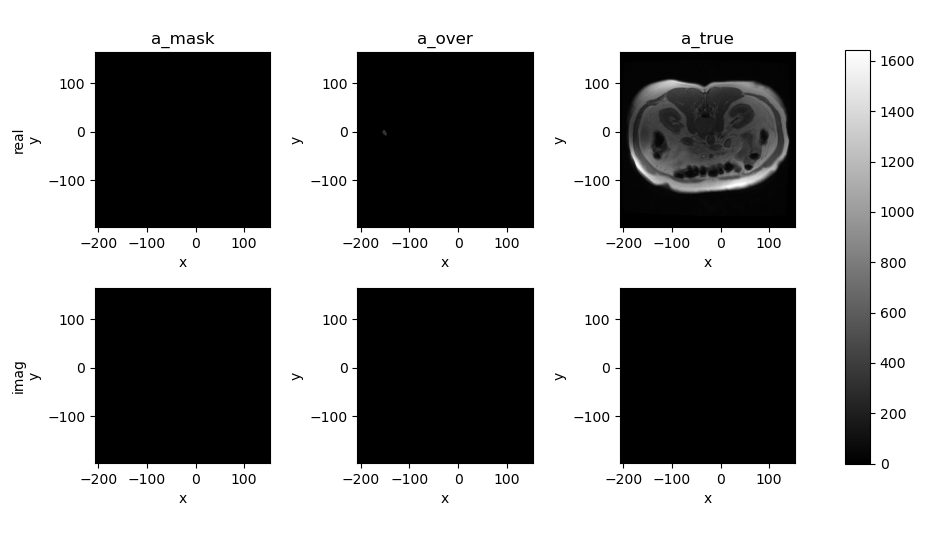

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


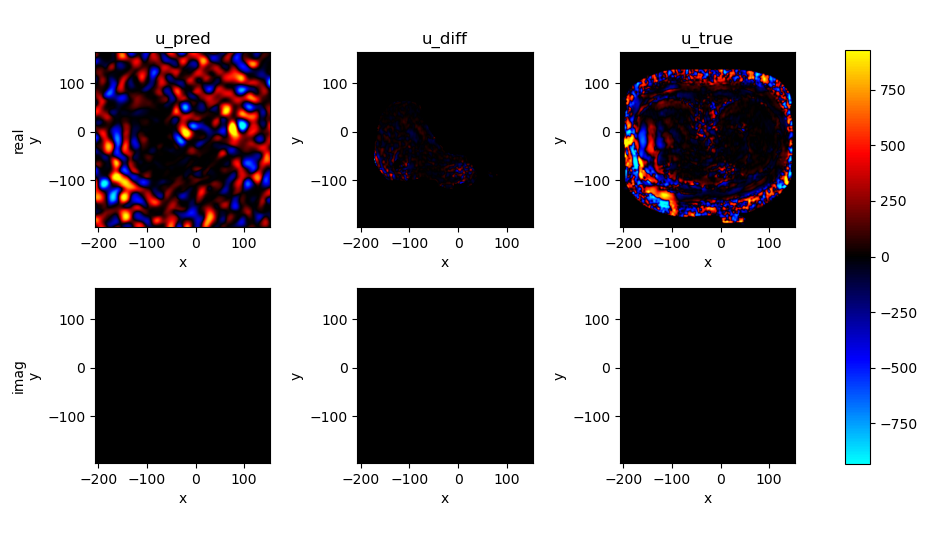

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


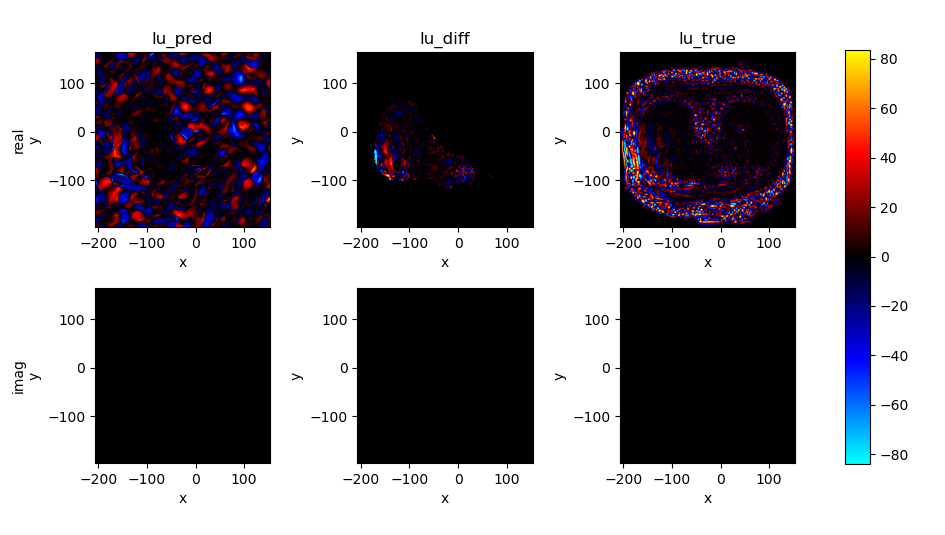

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


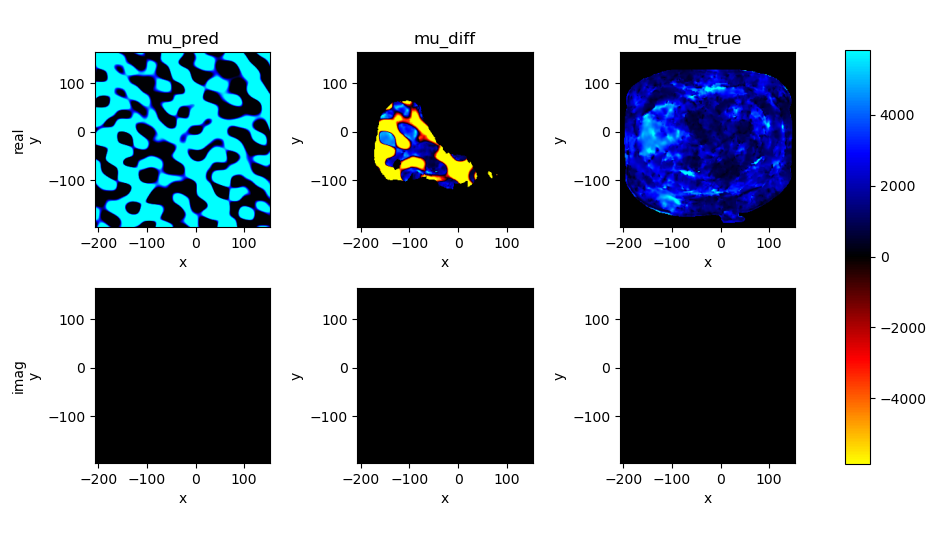

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [36]:
test_eval.model = model
test_eval.test()

In [37]:
torch.backends.cudnn.enabled = False

model.train(10000, display_every=10, callbacks=[test_eval])

Training model...

0         [7.53e+03, 3.48e+07]    [7.53e+03, 3.48e+07]    []  
Time spent testing: 18.23%
10        [7.52e+03, 1.34e+08]    [7.52e+03, 1.34e+08]    []  
Time spent testing: 22.64%
20        [7.51e+03, 7.41e+08]    [7.51e+03, 7.41e+08]    []  
Time spent testing: 25.42%
30        [7.49e+03, 3.03e+09]    [7.49e+03, 3.03e+09]    []  
Time spent testing: 28.55%
40        [7.45e+03, 9.72e+09]    [7.45e+03, 9.72e+09]    []  
Time spent testing: 30.14%
50        [7.39e+03, 2.61e+10]    [7.39e+03, 2.61e+10]    []  
Time spent testing: 31.00%
60        [7.32e+03, 6.01e+10]    [7.32e+03, 6.01e+10]    []  
Time spent testing: 31.39%
70        [7.22e+03, 1.22e+11]    [7.22e+03, 1.22e+11]    []  
Time spent testing: 30.82%
80        [7.09e+03, 2.29e+11]    [7.09e+03, 2.29e+11]    []  
Time spent testing: 33.25%
90        [6.94e+03, 3.97e+11]    [6.94e+03, 3.97e+11]    []  
Time spent testing: 33.62%
100       [6.77e+03, 6.44e+11]    [6.77e+03, 6.44e+11]    []  
Time spent testing

910       [1.40e+03, 5.49e+13]    [1.40e+03, 5.49e+13]    []  
Time spent testing: 44.84%
920       [1.40e+03, 5.51e+13]    [1.40e+03, 5.51e+13]    []  
Time spent testing: 45.29%
930       [1.39e+03, 5.52e+13]    [1.39e+03, 5.52e+13]    []  
Time spent testing: 45.23%
940       [1.39e+03, 5.52e+13]    [1.39e+03, 5.52e+13]    []  
Time spent testing: 45.18%
950       [1.38e+03, 5.54e+13]    [1.38e+03, 5.54e+13]    []  
Time spent testing: 45.13%
960       [1.37e+03, 5.55e+13]    [1.37e+03, 5.55e+13]    []  
Time spent testing: 45.33%
970       [1.37e+03, 5.56e+13]    [1.37e+03, 5.56e+13]    []  
Time spent testing: 45.76%
980       [1.36e+03, 5.56e+13]    [1.36e+03, 5.56e+13]    []  
Time spent testing: 45.71%
990       [1.35e+03, 5.57e+13]    [1.35e+03, 5.57e+13]    []  
Time spent testing: 45.61%
1000      [1.35e+03, 5.58e+13]    [1.35e+03, 5.58e+13]    []  
Time spent testing: 45.87%
1010      [1.34e+03, 5.59e+13]    [1.34e+03, 5.59e+13]    []  
Time spent testing: 45.82%
1020      

Time spent testing: 46.04%
1830      [1.00e+03, 6.04e+13]    [1.00e+03, 6.04e+13]    []  
Time spent testing: 46.24%
1840      [1.00e+03, 6.05e+13]    [1.00e+03, 6.05e+13]    []  
Time spent testing: 46.21%
1850      [9.98e+02, 6.04e+13]    [9.98e+02, 6.04e+13]    []  
Time spent testing: 46.13%
1860      [9.95e+02, 6.04e+13]    [9.95e+02, 6.04e+13]    []  
Time spent testing: 46.14%
1870      [9.91e+02, 6.05e+13]    [9.91e+02, 6.05e+13]    []  
Time spent testing: 46.11%
1880      [9.88e+02, 6.07e+13]    [9.88e+02, 6.07e+13]    []  
Time spent testing: 46.10%
1890      [9.86e+02, 6.11e+13]    [9.86e+02, 6.11e+13]    []  
Time spent testing: 46.23%
1900      [9.82e+02, 6.04e+13]    [9.82e+02, 6.04e+13]    []  
Time spent testing: 46.21%
1910      [9.79e+02, 6.07e+13]    [9.79e+02, 6.07e+13]    []  
Time spent testing: 46.17%
1920      [9.76e+02, 6.08e+13]    [9.76e+02, 6.08e+13]    []  
Time spent testing: 46.13%
1930      [9.73e+02, 6.07e+13]    [9.73e+02, 6.07e+13]    []  
Time spent


KeyboardInterrupt

